<a href="https://colab.research.google.com/github/leruc89656-NCHU/VAE-MNIST1/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Python 版本: ", torch.__version__)
print("GPU 是否可用: ", torch.cuda.is_available())

Python 版本:  2.8.0+cu126
GPU 是否可用:  True


In [4]:
import os, gzip
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 解決 OpenMP 警告
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#讀取影像檔案
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(16)
        buf = f.read()
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        return data.reshape(-1, 28, 28) / 255.0

In [7]:
#讀取標籤檔案
def load_mnist_labels(filename):
  with gzip.open(filename, 'rb') as f:
    f.read(8)
    buf = f.read()
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [8]:
train_images = load_mnist_images('/content/drive/MyDrive/DeepGenerativeModel/train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('/content/drive/MyDrive/DeepGenerativeModel/train-labels-idx1-ubyte.gz')
test_images = load_mnist_images('/content/drive/MyDrive/DeepGenerativeModel/t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('/content/drive/MyDrive/DeepGenerativeModel/t10k-labels-idx1-ubyte.gz')

In [9]:
train_dataset = TensorDataset(torch.tensor(train_images).view(-1, 784), torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_images).view(-1, 784), torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
    self.fc_dec2 = nn.Linear(hidden_dim, input_dim)

  def encode(self, x):
    h = torch.relu(self.fc1(x))
    return self.fc_mu(h), self.fc_logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = torch.relu(self.fc_dec1(z))
    return torch.sigmoid(self.fc_dec2(h))

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [11]:
def loss_function(recon_x, x, mu, logvar):
  BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(1, epochs+1):
  model.train()
  train_loss = 0
  for data, _ in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print(f'Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1 Average loss: 164.9762
Epoch 2 Average loss: 121.8184
Epoch 3 Average loss: 114.8711
Epoch 4 Average loss: 111.7112
Epoch 5 Average loss: 109.8133
Epoch 6 Average loss: 108.6850
Epoch 7 Average loss: 107.7929
Epoch 8 Average loss: 107.1641
Epoch 9 Average loss: 106.6435
Epoch 10 Average loss: 106.2242


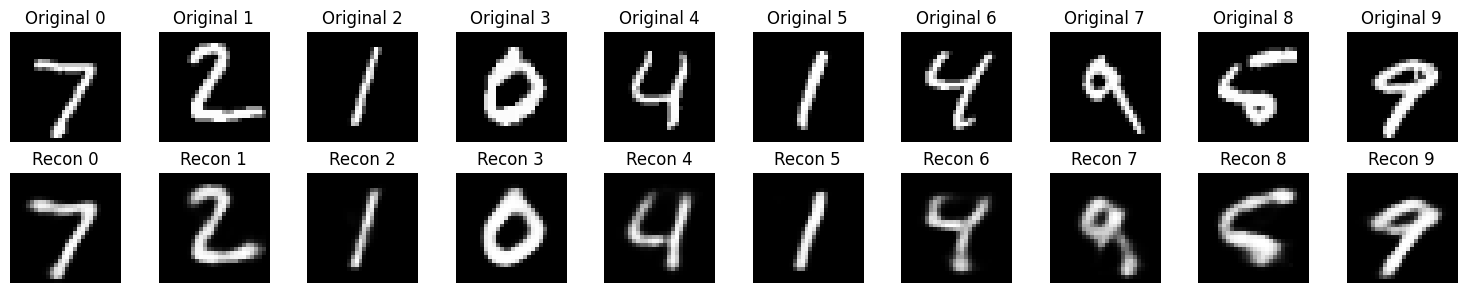

In [12]:
model.eval()
with torch.no_grad():
  batch, _ = next(iter(test_loader))
  batch = batch.to(device)
  recon, _, _ = model(batch)
  recon = recon.view(-1, 28, 28).cpu().numpy()
  originals = batch.view(-1, 28, 28).cpu().numpy()

# 顯示前 10 張原始影像和重建影像
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(originals[i], cmap='gray')
    axes[0, i].set_title(f'Original {i}')
    axes[0, i].axis('off')

    axes[1, i].imshow(recon[i], cmap='gray')
    axes[1, i].set_title(f'Recon {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()